In [1]:
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"} # As everything is eager by default in tf 2.0 


import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.compat.v1.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.compat.v1.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.compat.v1.InteractiveSession(config=config)

reset_sess()

In [2]:


parameter = tfd.Exponential(rate=1., name="poisson_param").sample()
print(parameter)
rv_data_generator = tfd.Poisson(parameter, name="data_generator")
print(rv_data_generator)
data_generator = rv_data_generator.sample()
print(data_generator)
if tf.executing_eagerly():
    data_generator_ = tf.nest.pack_sequence_as(
        data_generator,
        [t.numpy() if tf.is_tensor(t) else t
         for t in tf.nest.flatten(data_generator)])
else:
    data_generator_ = sess.run(data_generator)
    
print("Value of sample from data generator random variable:", data_generator_)



tf.Tensor(1.3617641, shape=(), dtype=float32)
tfp.distributions.Poisson("data_generator/", batch_shape=[], event_shape=[], dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
Value of sample from data generator random variable: 1.0


In [3]:
def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)

In [4]:
# Defining our Assumptions
parameter = tfd.Exponential(rate=1., name="poisson_param").sample()

# Converting our TF to Numpy
[ parameter_ ] = evaluate([ parameter ])

print("Sample from exponential distribution before evaluation: ", parameter)
print("Evaluated sample from exponential distribution: ", parameter_)

Sample from exponential distribution before evaluation:  tf.Tensor(1.0964648, shape=(), dtype=float32)
Evaluated sample from exponential distribution:  1.0964648


In [5]:


[ 
    parameter_,
    data_generator_,
] = evaluate([ 
    parameter, 
    data_generator,
])

print("'parameter_' evaluated Tensor :", parameter_)
print("'data_generator_' sample evaluated Tensor :", data_generator_)



'parameter_' evaluated Tensor : 1.0964648
'data_generator_' sample evaluated Tensor : 1.0


In [8]:


lambda_1 = tfd.Exponential(rate=1., name="lambda_1") #stochastic variable
lambda_2 = tfd.Exponential(rate=1., name="lambda_2") #stochastic variable
tau = tfd.Uniform(name="tau", low=0., high=10.) #stochastic variable

# deterministic variable since we are getting results of lambda's after sampling    
new_deterministic_variable = tfd.Deterministic(name="deterministic_variable", 
                                               loc=(lambda_1.sample() + lambda_2.sample()))
print(lambda_1.sample())
print(lambda_2.sample())
print(new_deterministic_variable)

tf.Tensor(1.5513742, shape=(), dtype=float32)
tf.Tensor(0.24573523, shape=(), dtype=float32)
tfp.distributions.Deterministic("deterministic_variable/", batch_shape=[], event_shape=[], dtype=float32)


In [35]:
# Build graph
# days
n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
print(idx)
print(tau.sample())
print(lambda_1.sample())
print(lambda_2.sample())
# for n_data_points samples, select from lambda_2 if sampled tau >= day value, lambda_1 otherwise
rv_lambda_deterministic = tfd.Deterministic(tf.gather([lambda_1.sample(), lambda_2.sample()],
                    indices=tf.compat.v1.to_int32(tau.sample() >= idx)))

lambda_deterministic = rv_lambda_deterministic.sample()
# Execute graph
[lambda_deterministic_] = evaluate([lambda_deterministic])
# Show results
print("{} samples from our deterministic lambda model: \n".format(n_data_points), lambda_deterministic_ )

lambda_deterministic = rv_lambda_deterministic.sample()
[lambda_deterministic_] = evaluate([lambda_deterministic])
# Show results
print("{} samples from our deterministic lambda model: \n".format(n_data_points), lambda_deterministic_ )



[0 1 2 3 4]
tf.Tensor(8.163813, shape=(), dtype=float32)
tf.Tensor(0.98311496, shape=(), dtype=float32)
tf.Tensor(0.12876458, shape=(), dtype=float32)
5 samples from our deterministic lambda model: 
 [0.14412032 0.14412032 0.14412032 0.14412032 0.14412032]
5 samples from our deterministic lambda model: 
 [0.14412032 0.14412032 0.14412032 0.14412032 0.14412032]


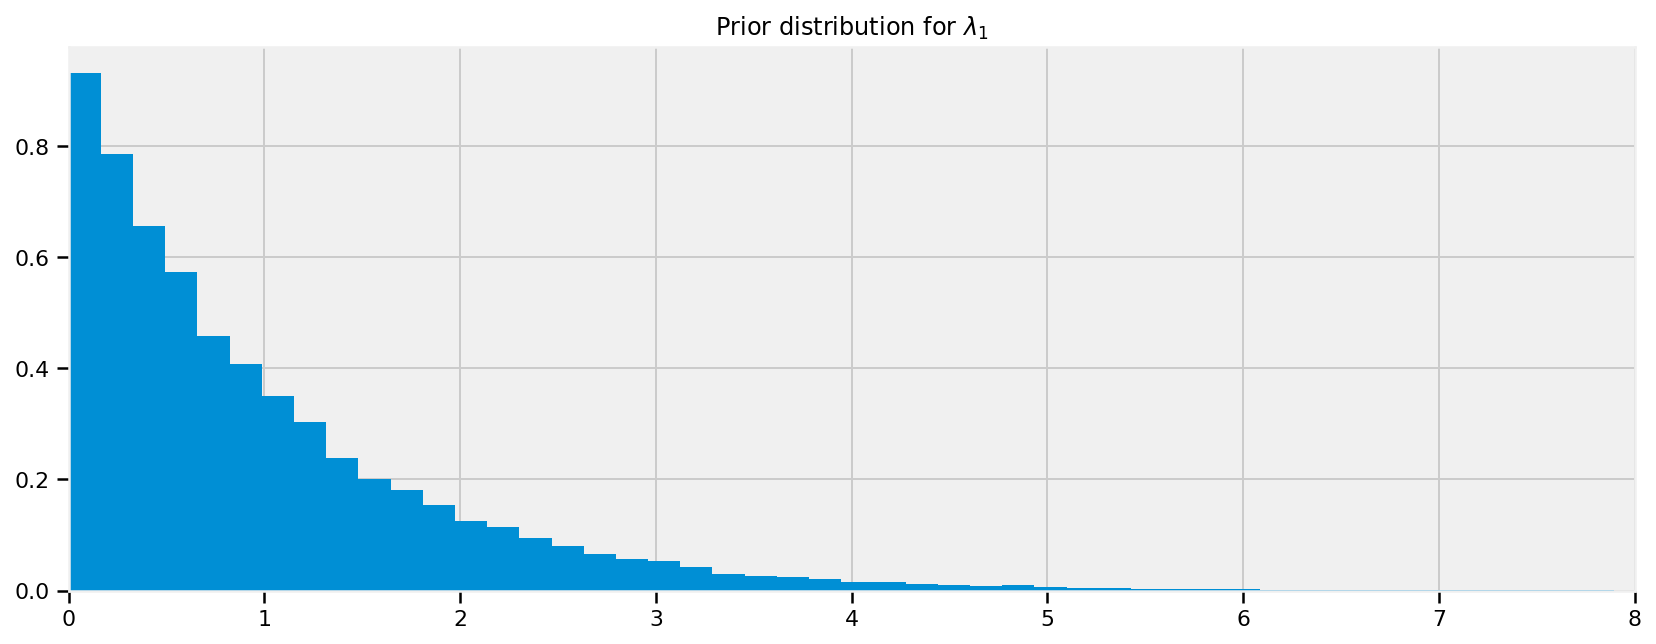

In [36]:
rv_lambda_1 = tfd.Exponential(rate=1., name="lambda_1")
lambda_1 = rv_lambda_1.sample(sample_shape=20000)
    
# Execute graph, convert TF to NumPy
[ lambda_1_ ] = evaluate([ lambda_1 ])

# Visualize our stepwise prior distribution
plt.figure(figsize(12.5, 5))
plt.hist(lambda_1_, bins=70, normed=True, histtype="stepfilled")
plt.title(r"Prior distribution for $\lambda_1$")
plt.xlim(0, 8);



In [39]:
# Build graph
data = tf.constant([10., 5.], dtype=tf.float32)
rv_poisson = tfd.Poisson(rate=1./tf.reduce_mean(data))
poisson = rv_poisson.sample()
print(poisson)
# Execute graph
[ data_, poisson_, ] = evaluate([ data, poisson ])

# Show results
print("two predetermined data points: ", data_)
print("\n mean of our data: ", np.mean(data_))
print("\n random sample from poisson distribution \n with the mean as the poisson's rate: \n", poisson_)


tf.Tensor(0.0, shape=(), dtype=float32)
two predetermined data points:  [10.  5.]

 mean of our data:  7.5

 random sample from poisson distribution 
 with the mean as the poisson's rate: 
 0.0


In [51]:
tau = tf.compat.v1.random_uniform(shape=[1], minval=0, maxval=80, dtype=tf.int32)

[ tau_ ] = evaluate([ tau ])

print("Value of Tau (randomly taken from DiscreteUniform(0, 80)):", tau_)

Value of Tau (randomly taken from DiscreteUniform(0, 80)): [75]


In [52]:
alpha = 1./8.

lambdas  = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2])  
[ lambda_1_, lambda_2_ ] = evaluate( lambdas )
print("Lambda 1 (randomly taken from Gamma(α) distribution): ", lambda_1_)
print("Lambda 2 (randomly taken from Gamma(α) distribution): ", lambda_2_)

Lambda 1 (randomly taken from Gamma(α) distribution):  20.582647
Lambda 2 (randomly taken from Gamma(α) distribution):  23.258606


In [53]:
data = tf.concat([tfd.Poisson(rate=lambda_1_).sample(sample_shape=tau_),
                      tfd.Poisson(rate=lambda_2_).sample(sample_shape= (80 - tau_))], axis=0)
days_range = tf.range(80)
[ data_, days_range_ ] = evaluate([ data, days_range ])
print("Artificial day-by-day user SMS count created by sampling: \n", data_)

Artificial day-by-day user SMS count created by sampling: 
 [21. 16. 17. 15. 14. 17. 20. 22. 20. 16. 23. 18. 28. 23. 22. 21. 20. 19.
 23. 27. 16. 15. 17. 15. 21. 19. 15. 18. 23. 20. 29. 26. 15. 32. 17. 23.
 17. 13. 25. 22. 23. 26. 17. 22. 26. 28. 17. 23. 19. 20. 24. 22. 12. 33.
 19.  8. 24. 15. 12. 20. 14. 31. 21. 19. 27. 23. 14. 20. 25. 19. 20. 16.
 29. 24. 19. 20. 21. 22. 26. 24.]


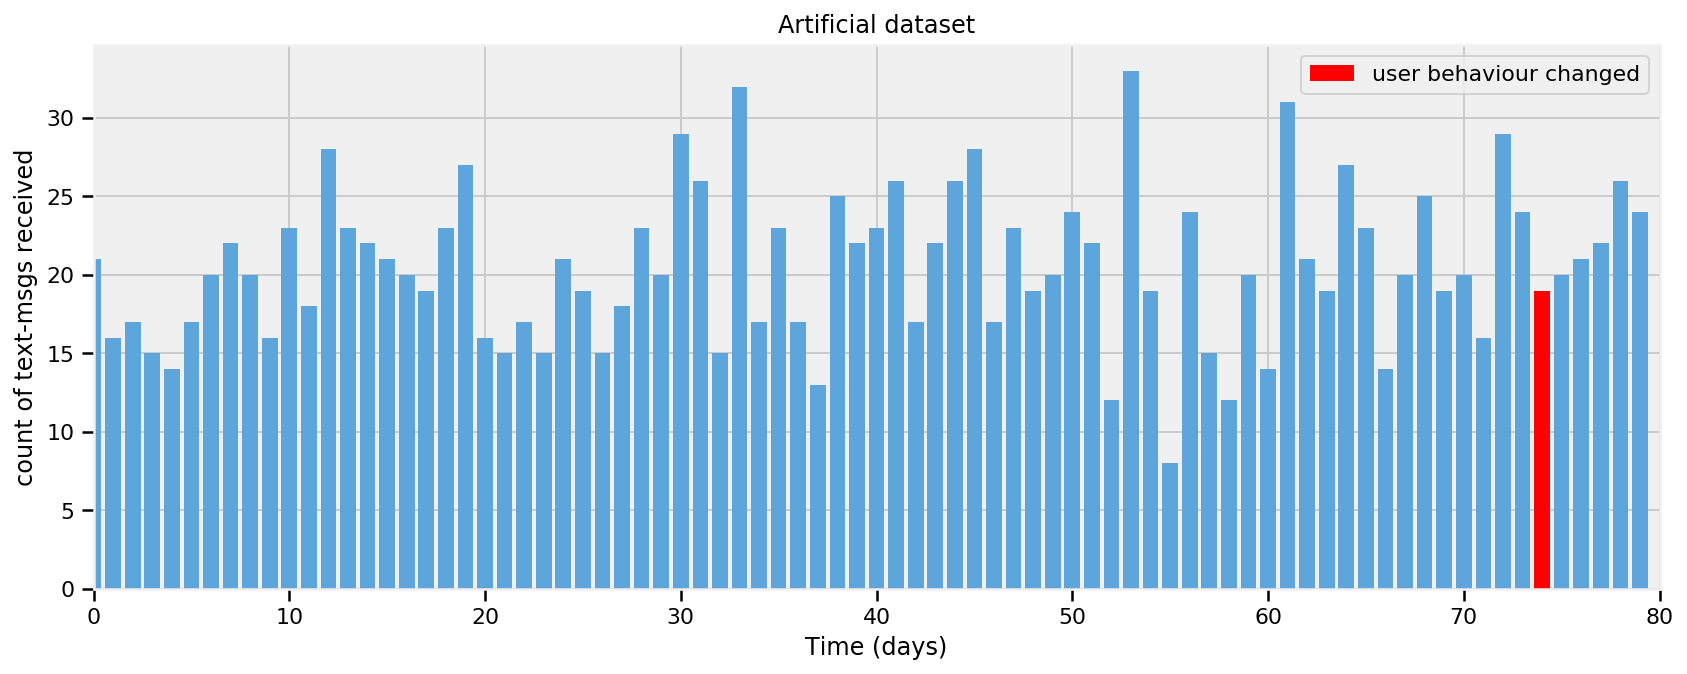

In [54]:


plt.bar(days_range_, data_, color=TFColor[3])
plt.bar(tau_ - 1, data_[tau_ - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();



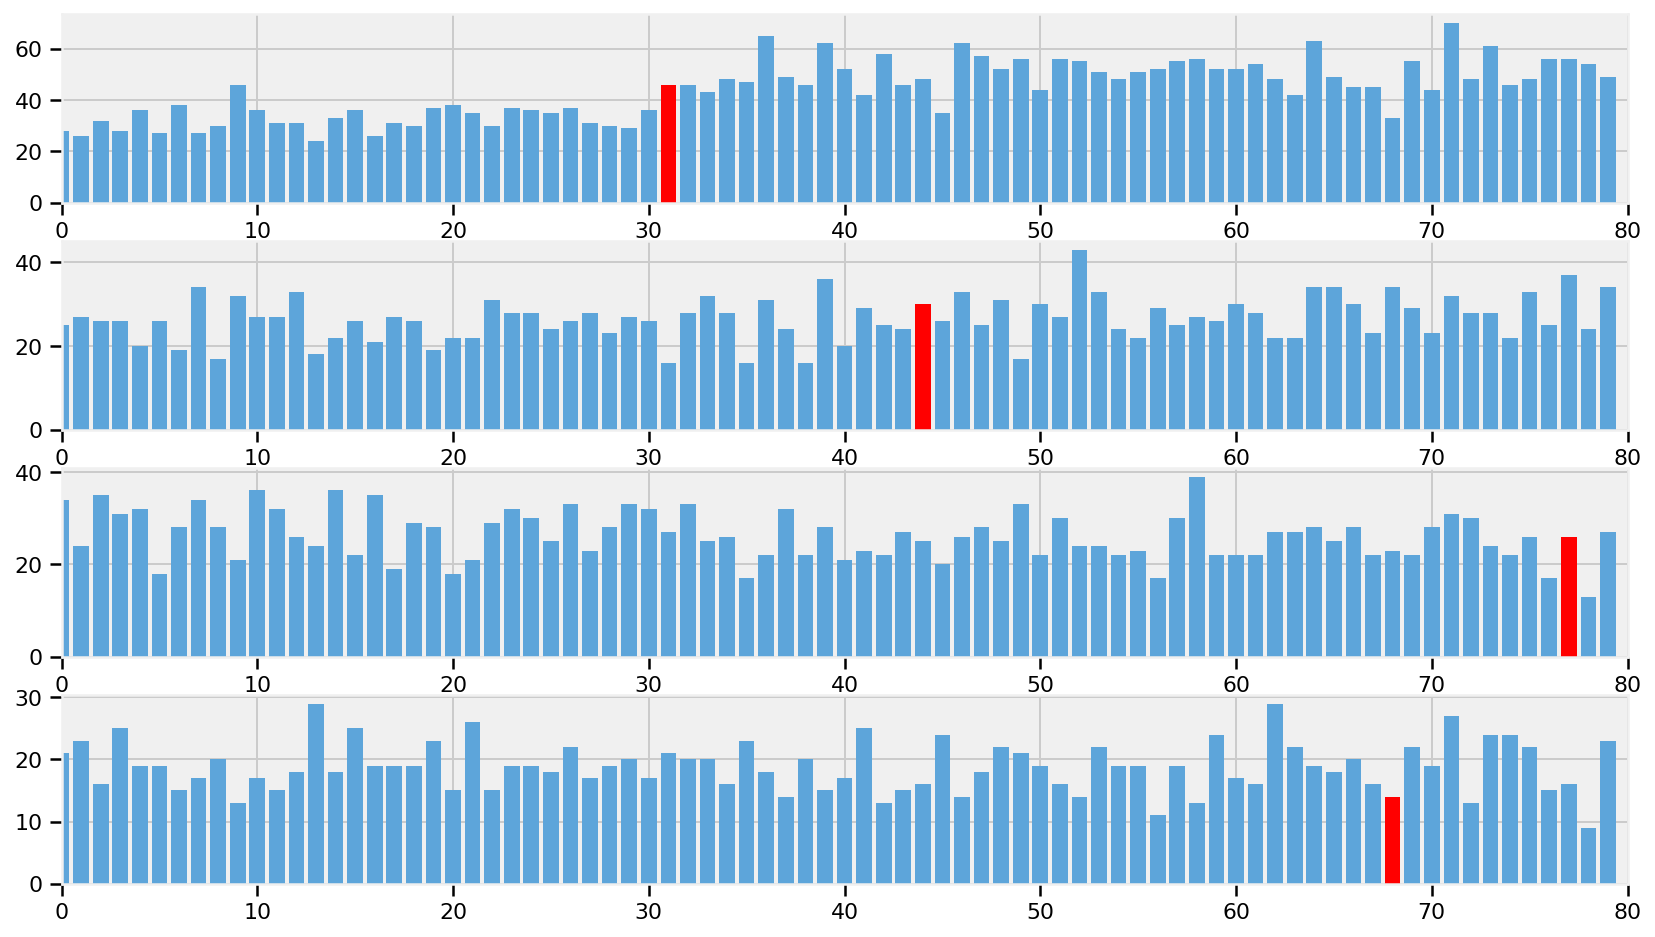

In [56]:
def plot_artificial_sms_dataset():   
    tau = tf.compat.v1.random_uniform(shape=[1], 
                            minval=0, 
                            maxval=80,
                            dtype=tf.int32)
    alpha = 1./8.
    lambdas  = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2]) 
    [ lambda_1_, lambda_2_ ] = evaluate( lambdas )
    data = tf.concat([tfd.Poisson(rate=lambda_1_).sample(sample_shape=tau),
                      tfd.Poisson(rate=lambda_2_).sample(sample_shape= (80 - tau))], axis=0)
    days_range = tf.range(80)
    
    [ 
        tau_,
        data_,
        days_range_,
    ] = evaluate([ 
        tau,
        data,
        days_range,
    ])
    
    plt.bar(days_range_, data_, color=TFColor[3])
    plt.bar(tau_ - 1, data_[tau_ - 1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

plt.figure(figsize(12.5, 8))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

